In [6]:
# Dask puts out more advisory logging that we care for.
# It takes some doing to quiet all of it, but this recipe works.
import dask
import logging
import dask_jobqueue
from dask.dataframe.utils import make_meta
from dask.distributed import Client

dask.config.set({"logging.distributed": "critical"})

# This also has to be done, for the above to be effective
logger = logging.getLogger("distributed")
logger.setLevel(logging.CRITICAL)

import warnings

# Finally, suppress the specific warning about Dask dashboard port usage
warnings.filterwarnings("ignore", message="Port 8787 is already in use.")

from pathlib import Path

import numpy as np
import pandas as pd
from astropy.io import ascii
import matplotlib.pyplot as plt
import time

from hats import read_hats

import lsdb

from catalog_filtering import bandFilterLenient, contains_PM
import hpms_pipeline as hpms

print("Imported libraries.")

Imported libraries.


In [61]:
# Directory variables
BENCHMARK_CATALOG_DIR = Path("../../../../catalogs/benchmark_catalogs")
two_deg_cs_name = "2.306965202564744e+18"
TWO_DEG_CS_DIR = BENCHMARK_DIR / two_deg_cs_name
mc_name = two_deg_cs_name.replace(".", "", 1).replace("+", "", 1)  + "_25_arcsec_mc"
MC_DIR = BENCHMARK_DIR / mc_name
two_deg_cs_catalog = lsdb.read_hats(TWO_DEG_CS_DIR, margin_cache=MC_DIR)

CATALOG_DIR = Path("../../../../catalogs")
MC_DIR = CATALOG_DIR / "margin_caches"
DES_DIR = CATALOG_DIR / "des_light"
DES_MC = MC_DIR / "des_margin_cache_18_arcsec"

# Filter variables
bandList = ['G','R','I','Z','Y']
class_star = None
spread_model = 0.05
magnitude_error = 0.05
check_flags = True
query_string = bandFilterLenient(
    bandList,
    classStar=class_star,
    spreadModel=spread_model,
    magError=magnitude_error,
    flag=check_flags,
    mag= 0
)
des_cols = (
    [f'CLASS_STAR_{band}' for band in bandList] + 
    [f'FLAGS_{band}' for band in bandList] + 
    ['RA','DEC','COADD_OBJECT_ID'] + 
    [f'SPREAD_MODEL_{band}' for band in bandList] + 
    [f'WAVG_MAG_PSF_{band}' for band in bandList] + 
    [f'WAVG_MAGERR_PSF_{band}' for band in bandList]
)
des_id_col = 'COADD_OBJECT_ID_1'
mag_cols = ['WAVG_MAG_PSF_I']

#Algorithm variables
k = 1
max_obj_deviation = 10
cone_search_rad = 50
max_neighbor_dist = 25
xmatch_max_neighbors = 100
min_neighbors = 3
print("Defined vars")

Defined vars


,CLASS_STAR_G,CLASS_STAR_R,CLASS_STAR_I,CLASS_STAR_Z,CLASS_STAR_Y,FLAGS_G,FLAGS_R,FLAGS_I,FLAGS_Z,FLAGS_Y,RA,DEC,COADD_OBJECT_ID,SPREAD_MODEL_G,SPREAD_MODEL_R,SPREAD_MODEL_I,SPREAD_MODEL_Z,SPREAD_MODEL_Y,WAVG_MAG_PSF_G,WAVG_MAG_PSF_R,WAVG_MAG_PSF_I,WAVG_MAG_PSF_Z,WAVG_MAG_PSF_Y,WAVG_MAGERR_PSF_G,WAVG_MAGERR_PSF_R,WAVG_MAGERR_PSF_I,WAVG_MAGERR_PSF_Z,WAVG_MAGERR_PSF_Y,NEPOCHS_G,NEPOCHS_R,NEPOCHS_I,NEPOCHS_Z,NEPOCHS_Y
_healpix_29,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2592746699573430477,0.005789,0.046427,0.911216,0.981644,0.842178,3,3,3,3,3,42.81831,-3.889707,1344189302,0.008623,0.010284,0.007479,0.007466,0.000033,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0
2592746699701155757,0.005172,0.982307,0.9952,0.994617,0.99233,3,3,3,3,3,42.818014,-3.889203,1344190158,-0.010239,0.001636,0.000212,-0.00144,0.000773,22.706379,19.362398,17.116657,15.483732,14.955669,0.05949,0.003771,0.001143,0.0008,0.001202,1,2,2,1,1
2592746699749998594,0.363681,0.980886,0.990194,0.132001,0.976497,3,3,3,3,3,42.817701,-3.888661,1344190301,0.00007,0.006571,0.000674,0.035627,0.015224,22.605766,19.425049,17.086205,-99.0,14.967874,0.044888,0.004398,0.001177,-99.0,0.001725,2,2,2,0,1
2592746699828024133,0.600814,0.689775,0.225051,0.151323,0.510317,1,1,1,1,1,42.819306,-3.888407,1344190267,0.013491,0.011738,0.004821,0.016491,-0.007653,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0


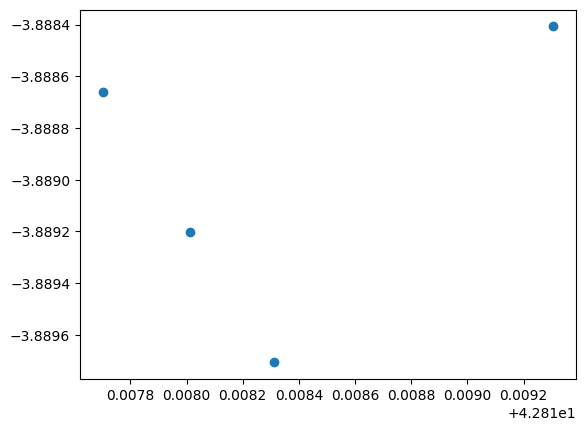

In [39]:
catalog_test_1 = lsdb.read_hats(DES_DIR, margin_cache=DES_MC).cone_search(ra=42.81831,dec=-3.889707,radius_arcsec=6)
df_1 = catalog_test_1.compute()
plt.scatter(df_1['RA'],df_1['DEC'])	
df_1

In [62]:
res_1 = hpms.execute_pipeline(catalog_test_1, query_string, xmatch_max_neighbors,
                              18, min_neighbors, k,
                              max_obj_deviation, des_id_col, mag_cols).compute()
res_1

,CLASS_STAR_G_2,CLASS_STAR_R_2,CLASS_STAR_I_2,CLASS_STAR_Z_2,CLASS_STAR_Y_2,FLAGS_G_2,FLAGS_R_2,FLAGS_I_2,FLAGS_Z_2,FLAGS_Y_2,RA_2,DEC_2,COADD_OBJECT_ID_2,SPREAD_MODEL_G_2,SPREAD_MODEL_R_2,SPREAD_MODEL_I_2,SPREAD_MODEL_Z_2,SPREAD_MODEL_Y_2,WAVG_MAG_PSF_G_2,WAVG_MAG_PSF_R_2,WAVG_MAG_PSF_I_2,WAVG_MAG_PSF_Z_2,WAVG_MAG_PSF_Y_2,WAVG_MAGERR_PSF_G_2,WAVG_MAGERR_PSF_R_2,WAVG_MAGERR_PSF_I_2,WAVG_MAGERR_PSF_Z_2,WAVG_MAGERR_PSF_Y_2,NEPOCHS_G_2,NEPOCHS_R_2,NEPOCHS_I_2,NEPOCHS_Z_2,NEPOCHS_Y_2,kth_min_deviation,max_obj_distance,max_mag_diff
COADD_OBJECT_ID_1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1344189302,0.005789,0.046427,0.911216,0.981644,0.842178,3,3,3,3,3,42.81831,-3.889707,1344189302,0.008623,0.010284,0.007479,0.007466,0.000033,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,0.016478,4.354796,0.030453
1344189302,0.005789,0.046427,0.911216,0.981644,0.842178,3,3,3,3,3,42.81831,-3.889707,1344189302,0.008623,0.010284,0.007479,0.007466,0.000033,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,0.007957,4.354796,0.030453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344190267,0.005789,0.046427,0.911216,0.981644,0.842178,3,3,3,3,3,42.81831,-3.889707,1344189302,0.008623,0.010284,0.007479,0.007466,0.000033,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,2.103227,5.836769,0.030453
1344190267,0.005789,0.046427,0.911216,0.981644,0.842178,3,3,3,3,3,42.81831,-3.889707,1344189302,0.008623,0.010284,0.007479,0.007466,0.000033,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0,0,0,0,0,1.946518,5.890652,NaN


In [60]:
from astropy.coordinates import SkyCoord
from astropy import units as u

left_most = SkyCoord(ra=42.817701 * u.deg,dec=-3.888661 * u.deg)
bottom_most = SkyCoord(ra=42.81831 * u.deg,dec=-3.889707 * u.deg)
right_most = SkyCoord(ra=42.819306 * u.deg,dec=-3.888407 * u.deg)
center = SkyCoord(ra=42.818014 * u.deg,dec=-3.889203 * u.deg)
print("LB",left_most.separation(bottom_most).arcsec)
print("LR",left_most.separation(right_most).arcsec)
print("CR",center.separation(right_most).arcsec)
print("BR",bottom_most.separation(right_most).arcsec)

LB 4.354796010947503
LR 5.836769120862464
CR 5.453972736149605
BR 5.890652325626567


In [65]:
print(res_1['max_obj_distance'].max())

5.890652325629106
